In [12]:
import random

import matplotlib.pyplot as plt
import numpy as np
import mcu
import cylinder_dataset_generator as cyl
from importlib import reload

reload(mcu)
reload(cyl)

<module 'cylinder_dataset_generator' from '/Users/Ekaterina.Inkina/Documents/Workspace/manifold-learning/cylinder_dataset_generator.py'>

In [32]:
reload(cyl)
reload(mcu)
cylinder_num = 200
cylinder_point_cnt = 200
deterministic_param_scatter = False
sorted = True
deterministic_scatter = True
lw = [0, 0]
up = [12, 6]
control_vars = cyl.get_congittrol_vars(deterministic=deterministic_param_scatter, size=cylinder_num, 
                                    lw = lw, up = up)
# control_vars = np.array([[1, 1], [1, 1],[1, 1], [1, 1], [1, 1],[1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2]])
cyllinders = cyl.generate_array_of_cylinders(control_vars, noise_level=0, 
                                             num_points=cylinder_point_cnt, sorted = sorted, deterministic_scatter=deterministic_scatter)
k = 6
c = 3000
standardized_x, centered_y, edges, y_means, y_scaler, x_means, x_stds = mcu.prepare_data(control_vars, cyllinders, k)

In [33]:
q = mcu.solve_semidefinite_programming(standardized_x, centered_y, edges, c)

In [34]:
reload(mcu)
reload(cyl)
ld_embedding = mcu.reduce_dimensions(q, 2)
regression_matrix = mcu.regress(ld_embedding, standardized_x)
reconstructed_y = np.dot(standardized_x, regression_matrix)

ld_embedding_to_params = np.dot(ld_embedding, np.linalg.inv(regression_matrix)) * x_stds + x_means
reconstructed_y_to_params = standardized_x * x_stds + x_means

rre = mcu.compute_rre(ld_embedding_to_params, reconstructed_y_to_params)
mcu.plot_rre_heatmap(np.linalg.norm(ld_embedding_to_params - reconstructed_y_to_params, axis=1), reconstructed_y_to_params)
print(np.median(rre))
mcu.plot_embeddings_vs_parameters(ld_embedding_to_params, reconstructed_y_to_params)
mcu.plot_graph(edges, ld_embedding_to_params, reconstructed_y_to_params)

SyntaxError: invalid syntax (mcu.py, line 1)

In [25]:
reload(cyl)
reload(mcu)
pieces_cnt = 5
test_data_size = 10
intervals = [np.linspace(lw[0], up[0], pieces_cnt+1), np.linspace(lw[1], up[1], pieces_cnt+1)]
interval_runs = np.empty(shape = (pieces_cnt, pieces_cnt, 3, 2))
for i in range(pieces_cnt):
    for j in range(pieces_cnt):
        interval_lw = [intervals[0][i], intervals[1][j]]
        interval_up = [intervals[0][i+1], intervals[1][j+1]]
        test_control_vars = cyl.get_control_vars(deterministic=False, size = test_data_size, lw = interval_lw, up = interval_up)
        test_rolls = cyl.generate_array_of_cylinders(test_control_vars, noise_level=0, num_points=cylinder_point_cnt, deterministic_scatter=False, sorted=True)
        x_opts = []
        for (roll, control_var) in zip(test_rolls, test_control_vars):
            x_opt, x_err = mcu.predictive_optimization(roll, centered_y, ld_embedding, regression_matrix, y_means, y_scaler, k)
            x_opt = x_opt * x_stds + x_means
            x_opts.append(x_opt)
            print("-----------")
            print(f"x_opt  = {x_opt}, x_err = {x_err}")
            print(f"x_real = {control_var}")
        x_ops = np.array(x_opts)
        test_control_vars = np.array(test_control_vars)
        errors = x_opts - test_control_vars
        errors0 = np.power(errors[:, 0], 2)
        errors1 = np.power(errors[:, 1], 2)
        errors_common = np.linalg.norm(errors, axis=1)
        interval_runs[i, j] = [[np.median(errors0), np.percentile(errors0, 75) - np.percentile(errors0, 25)],
                               [np.median(errors1), np.percentile(errors1, 75) - np.percentile(errors1, 25)],
                               [np.median(errors_common), np.percentile(errors_common, 75) - np.percentile(errors_common, 25)]]
        print(errors0)
        print(errors1)
        print(errors_common)

-----------
x_opt  = [1.6401756  2.18940241], x_err = 179.59368844701038
x_real = [0.75265301 1.13354585]
-----------
x_opt  = [1.8408992  0.85904342], x_err = 208.6462354173517
x_real = [0.62376235 0.20201261]
-----------
x_opt  = [1.6401756  0.85904342], x_err = 228.86053293616305
x_real = [0.75398932 0.28912035]
-----------
x_opt  = [4.56647983 0.85904342], x_err = 16.160540578081886
x_real = [2.38089499 0.88019006]
-----------
x_opt  = [4.01623562 0.85904342], x_err = 31.897333717907397
x_real = [2.16976437 0.25572349]
-----------
x_opt  = [4.54808083 0.88291832], x_err = 13.642719517214324
x_real = [1.90631959 0.80721249]
-----------
x_opt  = [1.6401756  1.44072878], x_err = 65.43808367858774
x_real = [1.82893097 0.80166728]
-----------
x_opt  = [1.6401756  1.01665075], x_err = 69.22200437820254
x_real = [1.59708018 0.26840329]
-----------
x_opt  = [1.6401756  0.85904342], x_err = 176.08817428034536
x_real = [1.01242961 0.15220816]
-----------
x_opt  = [4.74026102 0.85904342], x_e

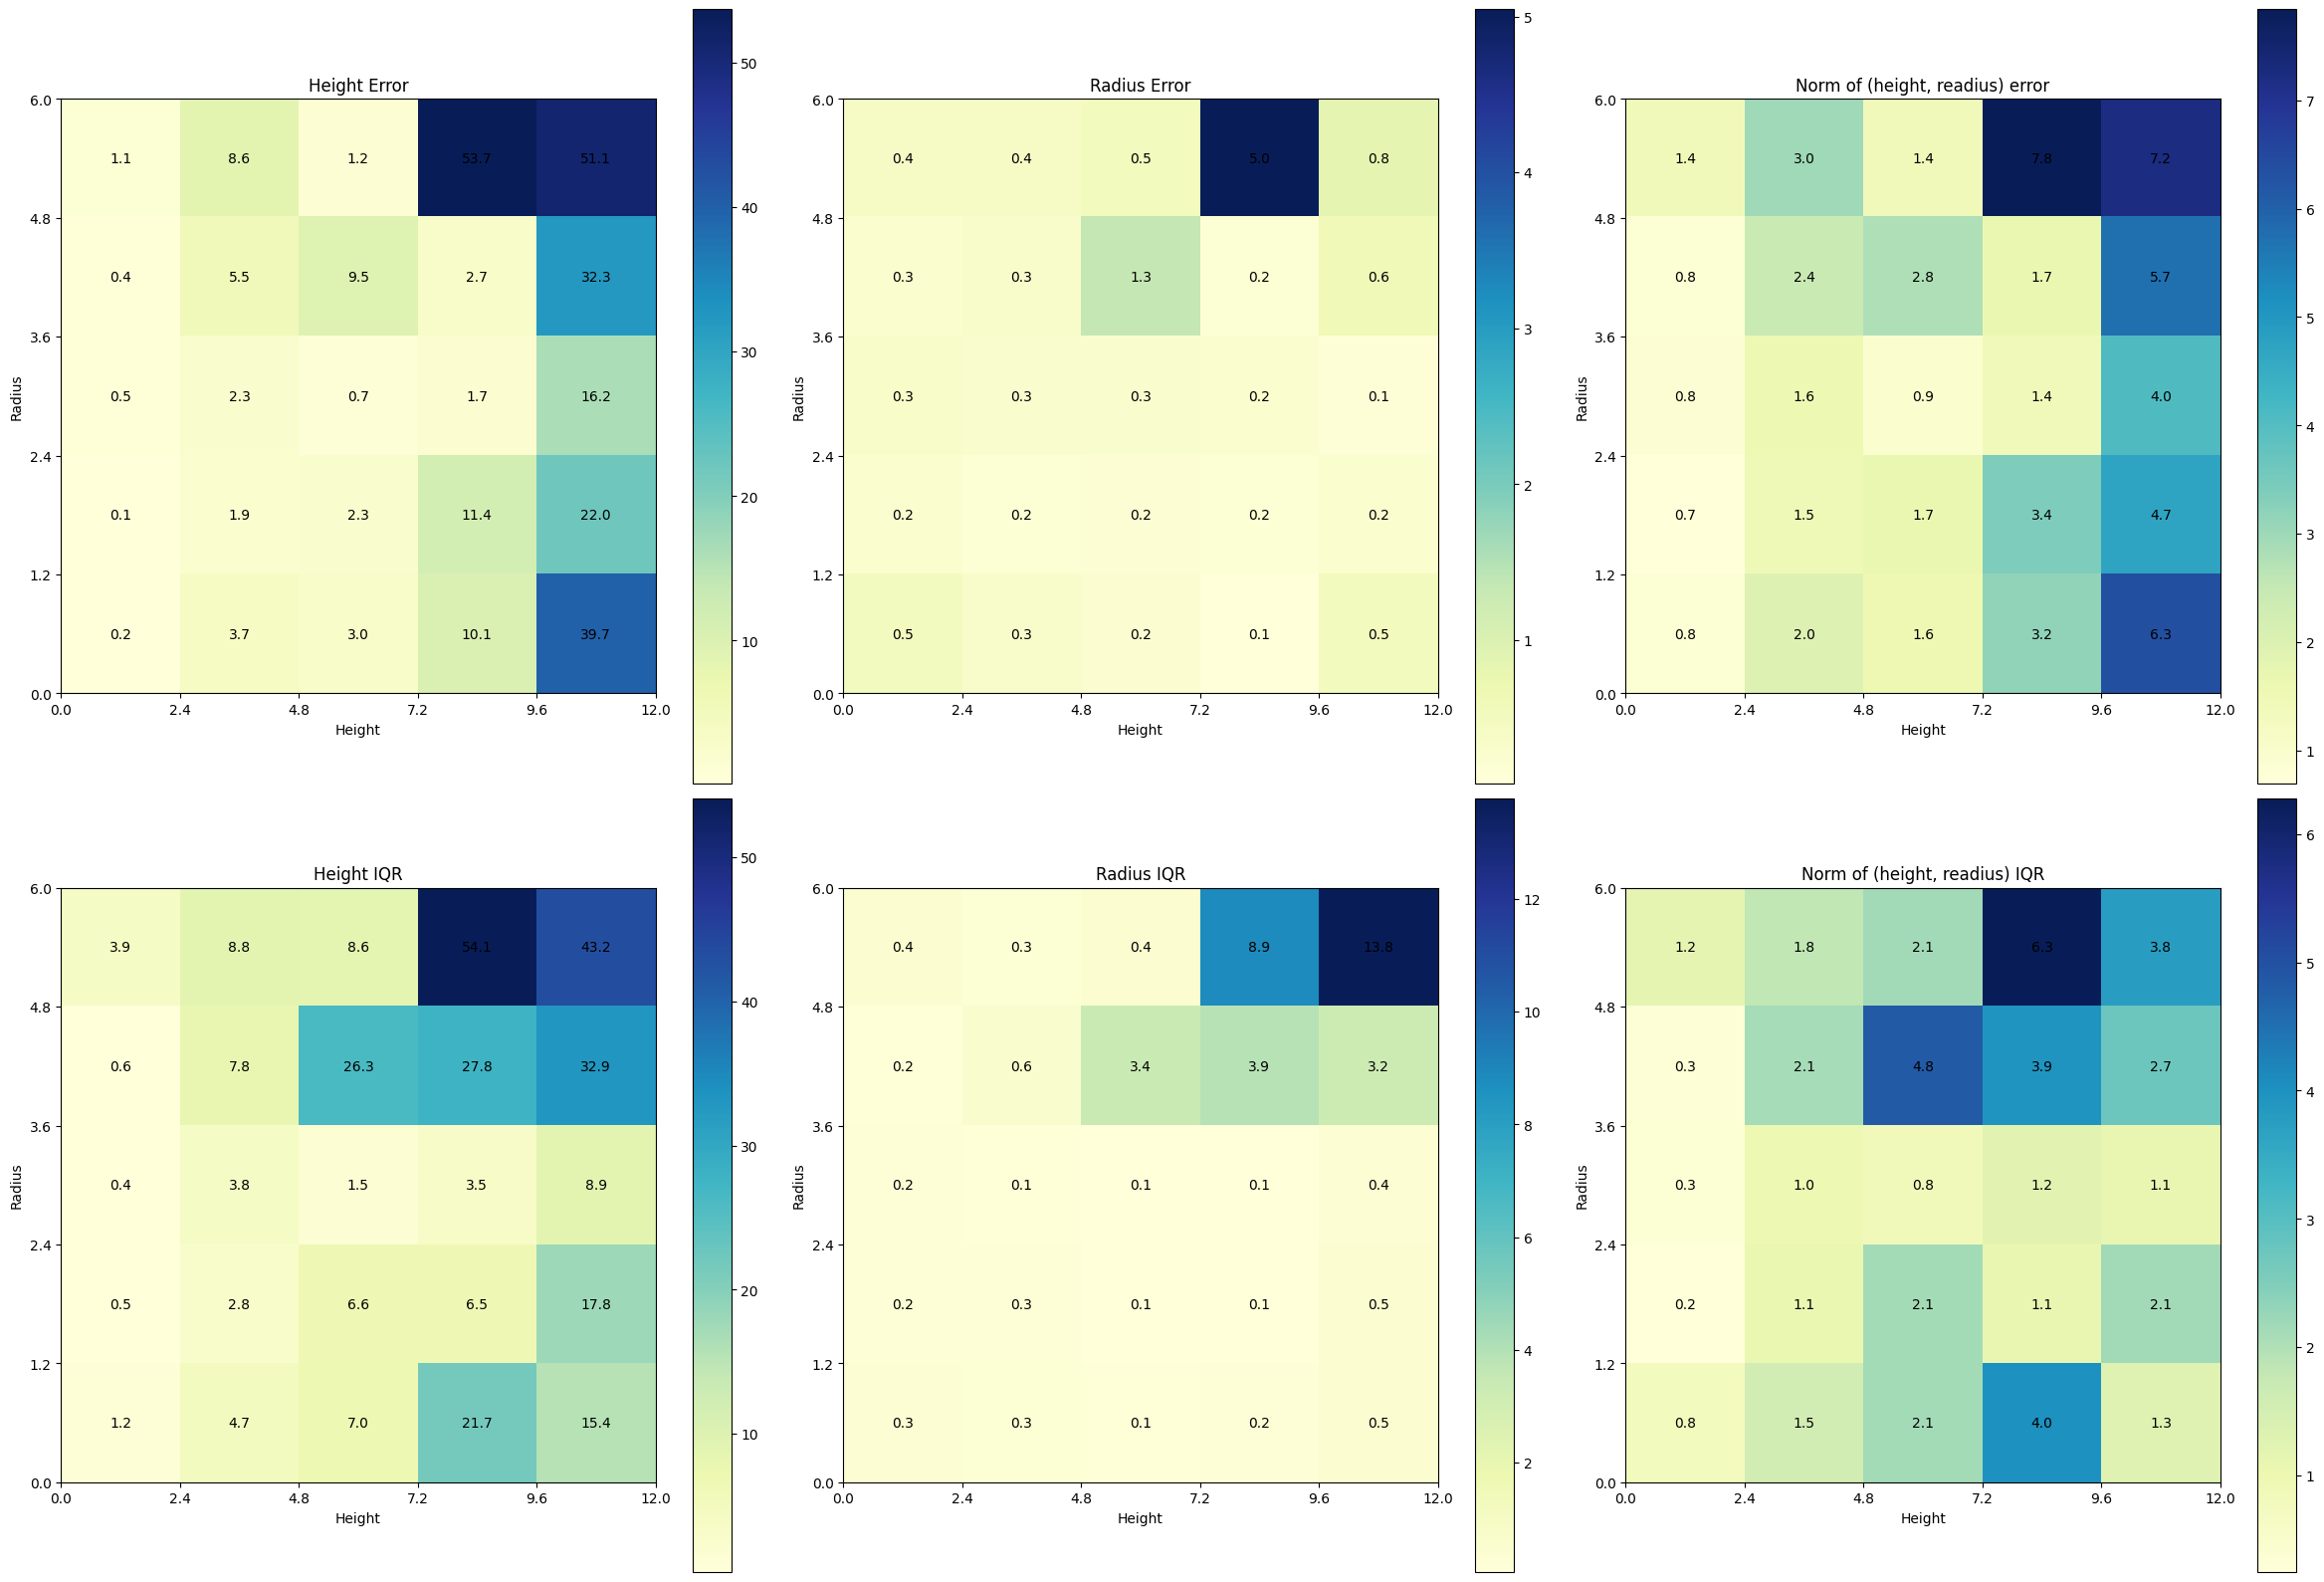

In [26]:
x_values = np.linspace(lw[0], up[0], pieces_cnt + 1)
y_values = np.linspace(lw[1], up[1], pieces_cnt + 1)[::-1]

fig, axs = plt.subplots(2, 3, figsize=(24, 16))

imgs = []
cbars = []

for k in range(3):
    imgs.append(axs[0, k].imshow(interval_runs[:, :, k, 0], cmap='YlGnBu', interpolation='nearest'))
    axs[0, k].set_xlabel('Height')
    axs[0, k].set_ylabel('Radius')
    axs[0, k].set_xticks(np.arange(pieces_cnt+1) - 0.5, [f'{x:.1f}' for x in x_values])
    axs[0, k].set_yticks(np.arange(pieces_cnt+1) - 0.5, [f'{y:.1f}' for y in y_values])
    fig.colorbar(imgs[-1], ax=axs[0, k])
    
    for i in range(pieces_cnt):
        for j in range(pieces_cnt):
            axs[0, k].text(j, i, f'{interval_runs[i, j, k, 0]:.1f}', ha='center', va='center', color='black')

axs[0, 0].set_title('Height Error')
axs[0, 1].set_title('Radius Error')
axs[0, 2].set_title('Norm of (height, readius) error')

for k in range(3):
    imgs.append(axs[1, k].imshow(interval_runs[:, :, k, 1], cmap='YlGnBu', interpolation='nearest'))
    axs[1, k].set_xlabel('Height')
    axs[1, k].set_ylabel('Radius')
    axs[1, k].set_xticks(np.arange(pieces_cnt+1) - 0.5, [f'{x:.1f}' for x in x_values])
    axs[1, k].set_yticks(np.arange(pieces_cnt+1) - 0.5, [f'{y:.1f}' for y in y_values])
    fig.colorbar(imgs[-1], ax=axs[1, k])

    for i in range(pieces_cnt):
        for j in range(pieces_cnt):
            axs[1, k].text(j, i, f'{interval_runs[i, j, k, 1]:.1f}', ha='center', va='center', color='black')

axs[1, 0].set_title('Height IQR')
axs[1, 1].set_title('Radius IQR')
axs[1, 2].set_title('Norm of (height, readius) IQR')


plt.tight_layout()
plt.show()

In [27]:
reload(cyl)
reload(mcu)
intervals = [np.linspace(lw[0], up[0], pieces_cnt+1), np.linspace(lw[1], up[1], pieces_cnt+1)]
interval_runs = np.empty(shape = (pieces_cnt, pieces_cnt, 3, 2))
for i in range(pieces_cnt):
    for j in range(pieces_cnt):
        interval_lw = [intervals[0][i+1], intervals[1][j+1]]
        interval_up = [intervals[0][i+1], intervals[1][j+1]]
        test_control_vars = cyl.get_control_vars(deterministic=False, size = test_data_size, lw = interval_lw, up = interval_up)
        test_rolls = cyl.generate_array_of_cylinders(test_control_vars, noise_level=0, num_points=cylinder_point_cnt, deterministic_scatter=True, sorted = True)
        x_opts = []
        for (roll, control_var) in zip(test_rolls, test_control_vars):
            x_opt, x_err = mcu.predictive_optimization(roll, centered_y, ld_embedding, regression_matrix, y_means, y_scaler, k)
            x_opt = x_opt * x_stds + x_means
            x_opts.append(x_opt)
            print("-----------")
            print(f"x_opt  = {x_opt}, x_err = {x_err}")
            print(f"x_real = {control_var}")
        x_ops = np.array(x_opts)
        test_control_vars = np.array(test_control_vars)
        errors = x_opts - test_control_vars
        errors0 = np.power(errors[:, 0], 2)
        errors1 = np.power(errors[:, 1], 2)
        errors_common = np.linalg.norm(errors, axis=1)
        interval_runs[i, j] = [[np.median(errors0), np.percentile(errors0, 75) - np.percentile(errors0, 25)],
                               [np.median(errors1), np.percentile(errors1, 75) - np.percentile(errors1, 25)],
                               [np.median(errors_common), np.percentile(errors_common, 75) - np.percentile(errors_common, 25)]]
        print(errors0)
        print(errors1)
        print(errors_common)

-----------
x_opt  = [2.78897093 1.10854157], x_err = 1.4896582803851952e-14
x_real = [2.4 1.2]
-----------
x_opt  = [2.78897094 1.10854159], x_err = 1.883832865989651e-14
x_real = [2.4 1.2]
-----------
x_opt  = [2.41125752 1.17467325], x_err = 6.4542223021645326e-12
x_real = [2.4 1.2]
-----------
x_opt  = [2.41125698 1.17467328], x_err = 1.8466349496252308e-14
x_real = [2.4 1.2]
-----------
x_opt  = [2.41125696 1.17467328], x_err = 5.0323683121091695e-14
x_real = [2.4 1.2]
-----------
x_opt  = [2.41125703 1.17467328], x_err = 3.9996164779556325e-14
x_real = [2.4 1.2]
-----------
x_opt  = [2.41125696 1.17467328], x_err = 2.6685810668100315e-14
x_real = [2.4 1.2]
-----------
x_opt  = [2.41125698 1.17467328], x_err = 1.6404299355319455e-14
x_real = [2.4 1.2]
-----------
x_opt  = [2.41125697 1.17467328], x_err = 1.3506691042976918e-14
x_real = [2.4 1.2]
-----------
x_opt  = [2.41125698 1.17467328], x_err = 1.575015391776573e-14
x_real = [2.4 1.2]
[1.51298382e-01 1.51298390e-01 1.26731820e

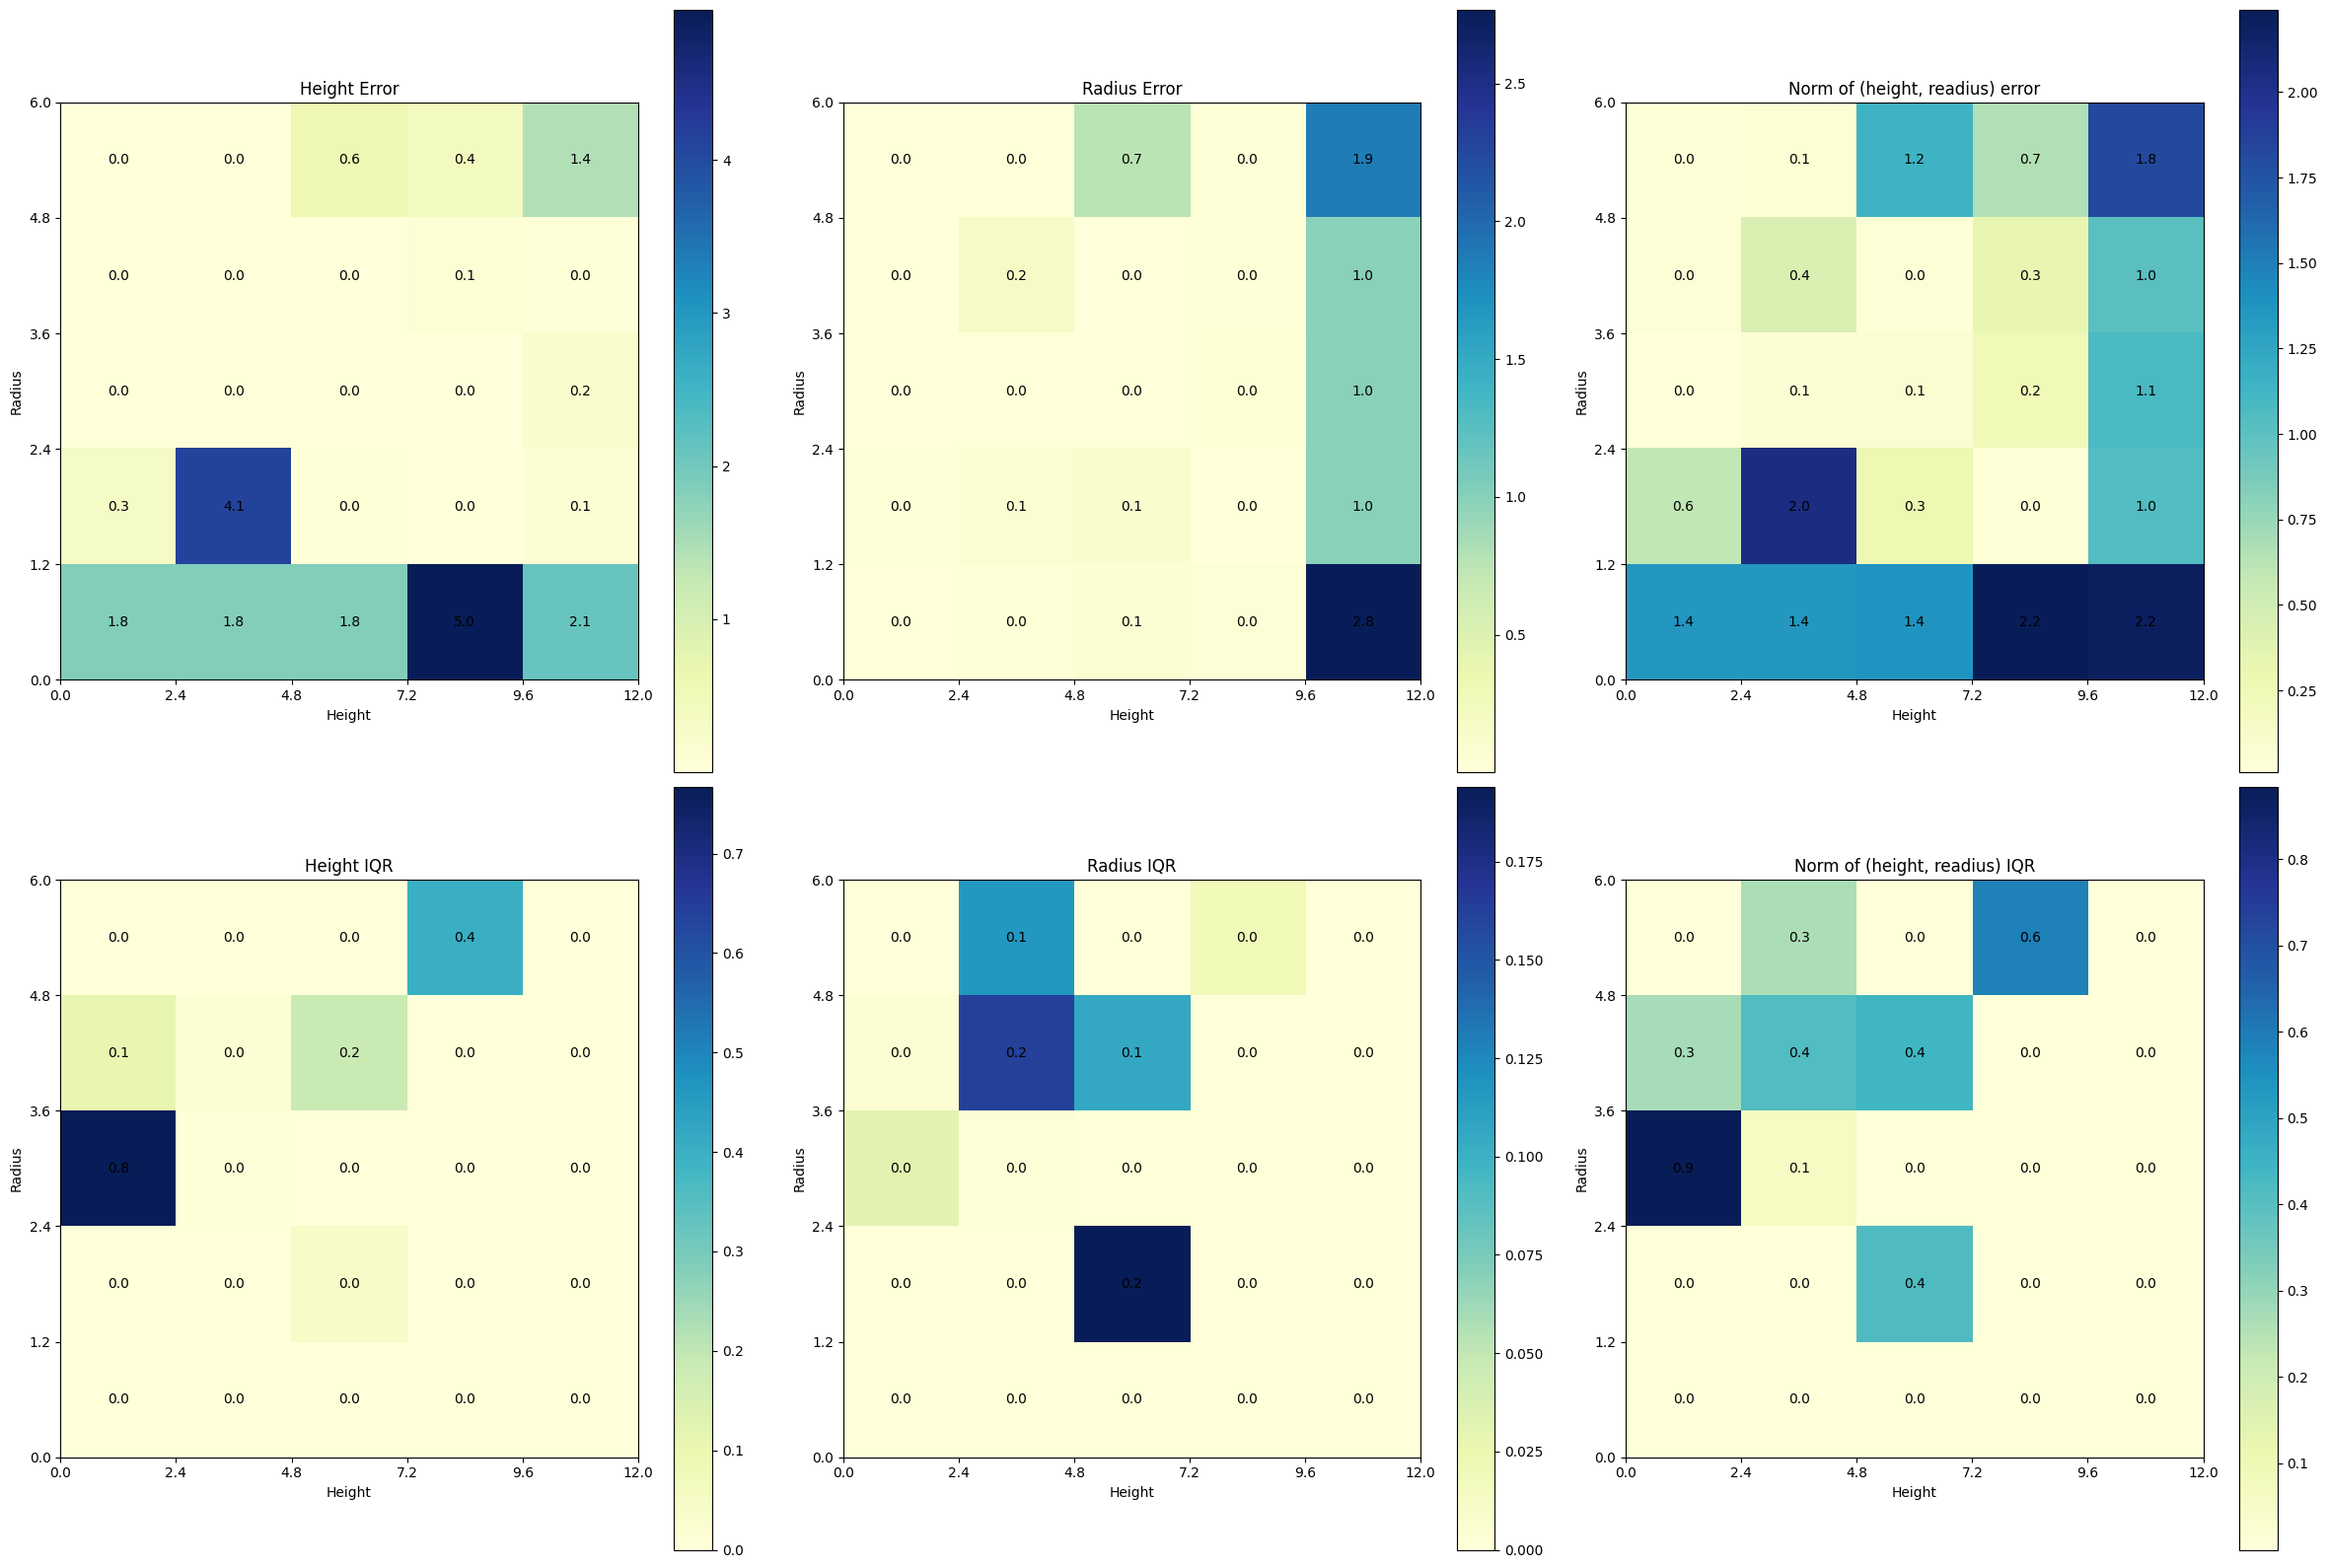

In [28]:
x_values = np.linspace(lw[0], up[0], pieces_cnt + 1)
y_values = np.linspace(lw[1], up[1], pieces_cnt + 1)[::-1]

fig, axs = plt.subplots(2, 3, figsize=(24, 16))

imgs = []
cbars = []

for k in range(3):
    imgs.append(axs[0, k].imshow(interval_runs[:, :, k, 0], cmap='YlGnBu', interpolation='nearest'))
    axs[0, k].set_xlabel('Height')
    axs[0, k].set_ylabel('Radius')
    axs[0, k].set_xticks(np.arange(pieces_cnt+1) - 0.5, [f'{x:.1f}' for x in x_values])
    axs[0, k].set_yticks(np.arange(pieces_cnt+1) - 0.5, [f'{y:.1f}' for y in y_values])
    fig.colorbar(imgs[-1], ax=axs[0, k])

    for i in range(pieces_cnt):
        for j in range(pieces_cnt):
            axs[0, k].text(j, i, f'{interval_runs[i, j, k, 0]:.1f}', ha='center', va='center', color='black')

axs[0, 0].set_title('Height Error')
axs[0, 1].set_title('Radius Error')
axs[0, 2].set_title('Norm of (height, readius) error')

for k in range(3):
    imgs.append(axs[1, k].imshow(interval_runs[:, :, k, 1], cmap='YlGnBu', interpolation='nearest'))
    axs[1, k].set_xlabel('Height')
    axs[1, k].set_ylabel('Radius')
    axs[1, k].set_xticks(np.arange(pieces_cnt+1) - 0.5, [f'{x:.1f}' for x in x_values])
    axs[1, k].set_yticks(np.arange(pieces_cnt+1) - 0.5, [f'{y:.1f}' for y in y_values])
    fig.colorbar(imgs[-1], ax=axs[1, k])

    for i in range(pieces_cnt):
        for j in range(pieces_cnt):
            axs[1, k].text(j, i, f'{interval_runs[i, j, k, 1]:.1f}', ha='center', va='center', color='black')

axs[1, 0].set_title('Height IQR')
axs[1, 1].set_title('Radius IQR')
axs[1, 2].set_title('Norm of (height, readius) IQR')


plt.tight_layout()
plt.show()